In [1]:
# Required python moduldes for opening FITS files and plotting
import numpy as np
import os
import os.path as op
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from astropy.io import fits
from astropy.table import Table, hstack
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb, ZScaleInterval
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles

In [2]:
version = 'v3.2' # Change to latest version.
source_table = Table.read(op.join('/kaggle/input/hetdexescv/hetdex_sc1_v3.2.ecsv'.format(version) ) )                      

#Data we are working with:

z_hetdex - redshift amount (the most important data we are workign with)

source_type = what we are looking at star, lyman alpha emitter, agn, lzg, oii

lum lya = lyman alpha emission (brightness) https://en.wikipedia.org/wiki/Lyman-alpha_line 

sdss_gmag = SDSS measures magnitudes in five wavelengths of light: Ultraviolet (u, Green (g, Red (r, Near infrared (i, Infrared (z. 

sn= signal to noise (how much distraction or noise ther eis) 

lum oii = brightness of oii (hydrogen alpha emission)  https://www.ucolick.org/~simard/phd/root/node21.html


Graphs that can be made:

Redshift histogram:
Z_hetdex (how many galaxies are at each redshift amount) 

Barchart: 
source_type
how many of each type of sources are we looking at

Scatter:
z_hetdex Redshift (x-axis)  vs. Gmag 
z_hetdex Redshift (x-axis)  vs. sn 
z_hetdex Redshift (x-axis)  vs. lum lya
z_hetdex Redshift (x-axis)  vs. lum oii


Scatter: FOR specificly different type of emitters: 
star, lyman alpha emitter, agn, lzg, oii

z_hetdex Redshift (x-axis)  vs. Gmag 
z_hetdex Redshift (x-axis)  vs. sn 
z_hetdex Redshift (x-axis)  vs. lum lya
z_hetdex Redshift (x-axis)  vs. lum oii



In [3]:
# Column Info

source_table.info

<Table length=232650>
     name      dtype          unit                                       description                                 n_bad 
------------- ------- ------------------- -------------------------------------------------------------------------- ------
  source_name   str26                                                                         HETDEX IAU designation      0
    source_id   int64                                                                       HETDEX Source Identifier      0
       shotid   int64                                             integer represent observation ID: int( date+obsid)      0
           RA float32                 deg                                       source_id right ascension (ICRS deg)      0
          DEC float32                 deg                                           source_id declination (ICRS deg)      0
         gmag float32                                                   sdss-g magnitude measured in HETDEX sp

I see in this data set, that there is ra and dec, and they are in the degrees.

The main focus for this dataset will be z_hetdex which is the 'spectroscopic redshift' data that 
says how relatively 'old' or far something is. The more redshift, the older the wave. 

Convert data table into pandas 

In [4]:
hetdexdf=source_table.to_pandas()

hetdexdf #we can see we converted our table into a dataframe in pandas (python's excel/sheets)

,source_name,source_id,shotid,RA,DEC,gmag,Av,z_hetdex,z_hetdex_src,z_hetdex_conf,...,lum_lya,lum_lya_err,lum_oii,lum_oii_err,flux_lya,flux_lya_err,flux_oii,flux_oii_err,sn,apcor
0,HETDEX J005604.29+000032.4,2140300000011,20181014010,14.017778,0.009023,22.096148,0.057882,-2.000,elixer,-1.0,...,NaN,NaN,9.728675e+39,1.481777e+39,NaN,NaN,9.714771,1.479659,NaN,0.921000
1,HETDEX J005604.29+000032.4,2140300000011,20180113006,14.017778,0.009023,21.276257,0.057863,-2.000,elixer,-1.0,...,NaN,NaN,7.494868e+39,1.688330e+39,NaN,NaN,7.484156,1.685917,NaN,0.936000
2,HETDEX J142914.44+510014.2,2140100002040,20190504015,217.310181,51.003937,23.528015,0.029085,-2.000,elixer,-1.0,...,NaN,NaN,4.682348e+40,7.165598e+39,NaN,NaN,7.267318,1.112149,8.05,0.941389
3,HETDEX J140222.64+510107.6,2140300000110,20180223010,210.594330,51.018787,22.087255,0.037425,-2.000,elixer,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.930000
4,HETDEX J011603.95-004509.7,2140100192799,20191224010,19.016335,-0.752552,22.246433,0.095883,-2.000,elixer,-1.0,...,NaN,NaN,2.133775e+41,7.109336e+39,NaN,NaN,38.490608,1.282434,11.90,0.915255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232645,HETDEX J110313.30+511646.4,2140100000297,20190501017,165.805222,51.279552,22.001179,0.025467,3.912,Liu+2022,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.17,0.931459
232646,HETDEX J161107.47+534208.0,2140100061927,20200527024,242.781128,53.702229,22.216864,0.036809,3.929,Liu+2022,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.57,0.878565
232647,HETDEX J125640.42+515940.8,2140000047179,20190403022,194.168396,51.994675,21.941465,0.024624,3.930,Liu+2022,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.22,0.925917
232648,HETDEX J140135.95+515711.7,2140000001451,20190504027,210.399796,51.953262,21.817234,0.035599,4.148,Liu+2022,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.05,0.938010


Now that you have the data frame for your space data, you need to import

COMAP points one , two, and three and cut out and combine the data that is from those three points. 


Tomorrow, we will also add the region stripe 82 in a seperate df. 

In [5]:
ra=hetdexdf.RA*u.deg
dec=hetdexdf.DEC*u.deg

allcoords=SkyCoord(ra, dec, frame='icrs', unit='deg')
allcoords

#COMAP overview Looking at +/-1.5 degrees around each of these three points 
COMAP_point_one = SkyCoord(ra='01h41m44.4s', dec='00d00m00s')
COMAP_point_two = SkyCoord(ra='11h20m00s', dec='52d30m00s')
COMAP_point_three = SkyCoord(ra='15h04m00s', dec='55d00m00s')

tol=1.5*u.deg


#this is going to create a array with the distances from the point for 'allcoords'
sep_point_one=allcoords.separation(COMAP_point_one)

#find the indicies of values (what rows) have data that are within the tolerance
fieldone_index=np.where(sep_point_one < tol)[0]


#this will take the specific rows that we know have data from
# the main data set and make a new dataframe with those points only
field_one_df=hetdexdf.iloc[fieldone_index]


In [6]:
sep_point_two=allcoords.separation(COMAP_point_two)
good_idx_two=np.where(sep_point_two<tol)[0]
field_two_df=hetdexdf.iloc[good_idx_two]

sep_point_three=allcoords.separation(COMAP_point_three)
good_idx_three=np.where(sep_point_three<tol)[0]
field_three_df=hetdexdf.iloc[good_idx_three]


#pd.concat (df1,df2,df3) combines several dataframes together) 
combined_df=pd.concat((field_one_df,field_two_df,field_three_df))

combined_df



,source_name,source_id,shotid,RA,DEC,gmag,Av,z_hetdex,z_hetdex_src,z_hetdex_conf,...,lum_lya,lum_lya_err,lum_oii,lum_oii_err,flux_lya,flux_lya_err,flux_oii,flux_oii_err,sn,apcor
30,HETDEX J013604.69-002806.4,2140100039333,20191222014,24.019552,-0.468454,22.367409,0.096020,-1.000000,elixer,-1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.971000
49,HETDEX J014008.26-000242.9,2140100039311,20200118009,25.034407,-0.045247,22.068237,0.084464,-1.000000,elixer,-1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.922000
99,HETDEX J014224.09+002702.3,2140100039505,20190105013,25.600368,0.450638,22.027975,0.097662,-1.000000,elixer,-1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.976000
125,HETDEX J014503.64-000345.6,2140100039569,20181011010,26.265146,-0.062678,22.087608,0.085750,-1.000000,elixer,-1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875000
141,HETDEX J014008.40-001136.8,2140100039585,20180822020,25.034983,-0.193553,22.017756,0.094533,-1.000000,elixer,-1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.932000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231520,HETDEX J150219.28+533546.2,2140100065178,20200525024,225.580338,53.596153,27.134979,0.044112,3.426397,elixer,0.098903,...,1.123051e+43,1.869950e+42,NaN,NaN,10.099308,1.681598,NaN,NaN,6.080000,0.934257
231744,HETDEX J150413.47+535415.1,2140100080782,20200425016,226.056122,53.904194,25.100616,0.039503,3.441118,elixer,0.094663,...,1.075518e+43,1.655486e+42,NaN,NaN,9.573452,1.473589,NaN,NaN,6.630000,0.919668
232015,HETDEX J150300.94+534405.7,2140000034212,20200525024,225.753937,53.734913,23.195499,0.037269,3.457100,Liu+2022,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.110001,0.934185
232188,HETDEX J150544.86+535755.7,2140100004195,20200524025,226.436920,53.965466,24.927547,0.040052,3.466329,elixer,0.099260,...,1.468493e+43,2.887168e+42,NaN,NaN,12.845826,2.525586,NaN,NaN,6.130000,0.873311


30        oii
49        oii
99        oii
125       oii
141       oii
         ... 
231520    lae
231744    lae
232015    agn
232188    lae
232642    agn
Name: source_type, Length: 10966, dtype: object

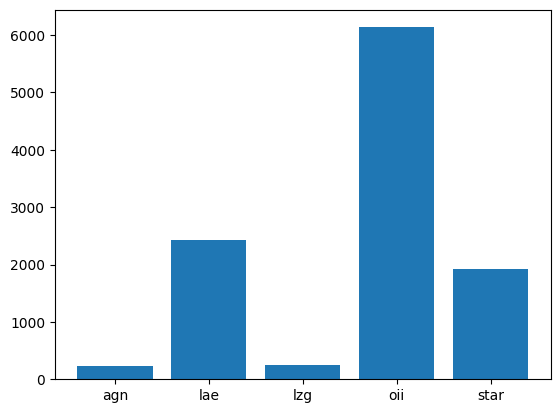

In [7]:
import pandas as pd
 
import matplotlib.pyplot as plt
 
import seaborn as sns

x=combined_df['source_type']

keys, counts=np.unique(x, return_counts=True)

plt.bar(keys, counts)

combined_df['source_type']
 

In [8]:
combined_df['source_type']

combined_agn=combined_df[combined_df['source_type']=='agn']


We have 11k data points that are within COMAP regions 1, 2, and 3 that are observable from this dataset. 

In [9]:
Stripedf=hetdexdf[(hetdexdf['RA']>60*u.degree)& (hetdexdf['RA']<300*u.degree) &(hetdexdf['DEC']>-1.26*u.degree) & (hetdexdf['DEC']<1.26*u.degree) ]

Stripedf


,source_name,source_id,shotid,RA,DEC,gmag,Av,z_hetdex,z_hetdex_src,z_hetdex_conf,...,lum_lya,lum_lya_err,lum_oii,lum_oii_err,flux_lya,flux_lya_err,flux_oii,flux_oii_err,sn,apcor


This dataset has no data in the stripe 82

In [10]:
HudlEboss=fits.open("/kaggle/input/extended-baryon-oscillation-spectroscopic-survey/DR16Q_v4.fits") #load my fits into a variable
#HudlEboss.info()



In [11]:
EbossHeader=HudlEboss[1].header #quick call for my header (prefer columns though after exploration)
Ebossdata=HudlEboss[1].data #quick call for the data that I have, that I will use to make a df or table 
#after research going to df (pandas) can result in a data loss, in 2016 there may have been an update
#for safe transition (will research)
#EbossHeader


In [12]:
Ebossdata.shape  #gives me the shape of the data structure 
Ebossdata.dtype.name

'record18320'

In [13]:
EbossCols=HudlEboss[1].columns   #much more useful than the .header option 
#EbossCols #cleanly view column titles 

Eboss Data source & table explanation:

https://data.sdss.org/datamodel/files/BOSS_QSO/DR16Q/DR16Q_v4.html 


AUTOCLASS_PQN: Object classification post-QuasarNET
What is it? Quasar (QSO)? Galaxy? etc. 
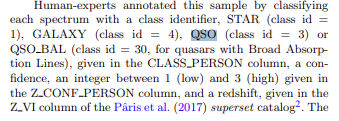
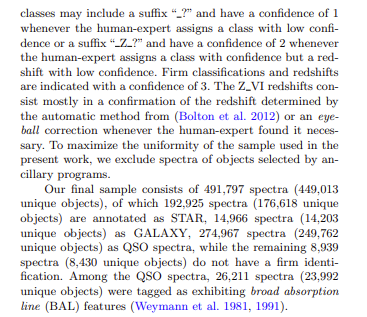

Z_QN = systemitc redshift (what we care about)


Z = Best available redshift taken from Z_VI, Z_PIPE, Z_DR12Q, Z_DR7Q_SCH, Z_DR6Q_HW, and Z_10K 

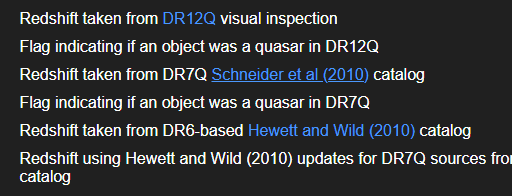 (these are the redshifts it is taking it from) 

M_I = Absolute I-band magnitude is a logarithmic measurement of the detected flux from an object. 
It's a way to describe the luminosity of a star. Luminosity is the total amount of energy radiated by a star per second

SN_MEDIAN_ALL=  Median S/N value of all good spectroscopic pixels (basically signal to nois) 

Z_HALPHA - redshift for hydrogen alpha emitter

Z_HBETA - redshift line for hydrogen beta 

Z_MGII redshift for magnesium II

Z_CIII redshift for CIII

Z_CIV redshift for CIV

Z_LYA redshift for Lyα 

PSFFLUX  - FLUX is the amount of energy from a luminous object that reaches a given surface or location. u, g, r, i z, are all the bands of light wea re lookign at https://en.wikipedia.org/wiki/Photometric_system

NUV : near ultra voiloet flux from one dataset (galex): 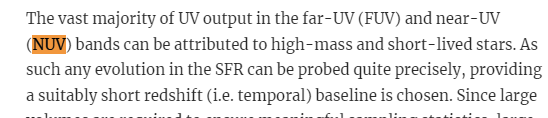

FUV:  far ultraviloet  FUV flux from one data set(galex) : 
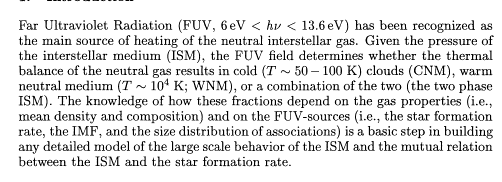






Graphs that can be made:

Redshift histogram:
Z (how many objects are at each redshift amount) 

Barchart: 
AUTOCLASS_PQN
how many of each type of sources are we looking at

Scatter:
z_hetdex Redshift (x-axis)  vs. Gmag 
z_hetdex Redshift (x-axis)  vs. sn 
z_hetdex Redshift (x-axis)  vs. lum lya
z_hetdex Redshift (x-axis)  vs. lum oii


Scatter: FOR specificly different type of emitters: 
star, lyman alpha emitter, agn, lzg, oii

z_hetdex Redshift (x-axis)  vs. Gmag 
z_hetdex Redshift (x-axis)  vs. sn 
z_hetdex Redshift (x-axis)  vs. lum lya
z_hetdex Redshift (x-axis)  vs. lum oii


In [14]:
Eboss_table = Table(HudlEboss[1].data)  #places all of the data from my set into a table form 
Eboss_table #outputs a view of the table, very clean and potentially as usable as a df, will try features
#unlike a df it also fully loads columns, just not rows.  


SDSS_NAME,RA,DEC,PLATE,MJD,FIBERID,AUTOCLASS_PQN,AUTOCLASS_DR14Q,IS_QSO_QN,Z_QN,RANDOM_SELECT,Z_10K,Z_CONF_10K,PIPE_CORR_10K,IS_QSO_10K,THING_ID,Z_VI,Z_CONF,CLASS_PERSON,Z_DR12Q,IS_QSO_DR12Q,Z_DR7Q_SCH,IS_QSO_DR7Q,Z_DR6Q_HW,Z_DR7Q_HW,IS_QSO_FINAL,Z,SOURCE_Z,Z_PIPE,ZWARNING,OBJID,Z_PCA,ZWARN_PCA,DELTACHI2_PCA,Z_HALPHA,ZWARN_HALPHA,DELTACHI2_HALPHA,Z_HBETA,ZWARN_HBETA,DELTACHI2_HBETA,Z_MGII,ZWARN_MGII,DELTACHI2_MGII,Z_CIII,ZWARN_CIII,DELTACHI2_CIII,Z_CIV,ZWARN_CIV,DELTACHI2_CIV,Z_LYA,ZWARN_LYA,DELTACHI2_LYA,Z_LYAWG,Z_DLA,NHI_DLA,CONF_DLA,BAL_PROB,BI_CIV,ERR_BI_CIV,AI_CIV,ERR_AI_CIV,BI_SIIV,ERR_BI_SIIV,AI_SIIV,ERR_AI_SIIV,BOSS_TARGET1,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,ANCILLARY_TARGET1,ANCILLARY_TARGET2,NSPEC_SDSS,NSPEC_BOSS,NSPEC,PLATE_DUPLICATE,MJD_DUPLICATE,FIBERID_DUPLICATE,SPECTRO_DUPLICATE,SKYVERSION,RUN_NUMBER,RERUN_NUMBER,CAMCOL_NUMBER,FIELD_NUMBER,ID_NUMBER,LAMBDA_EFF,ZOFFSET,XFOCAL,YFOCAL,CHUNK,TILE,PLATESN2,PSFFLUX,PSFFLUX_IVAR,PSFMAG,PSFMAGERR,EXTINCTION,M_I,SN_MEDIAN_ALL,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,W1_FLUX,W1_FLUX_IVAR,W1_MAG,W1_MAG_ERR,W1_CHI2,W1_FLUX_SNR,W1_SRC_FRAC,W1_EXT_FLUX,W1_EXT_FRAC,W1_NPIX,W2_FLUX,W2_FLUX_IVAR,W2_MAG,W2_MAG_ERR,W2_CHI2,W2_FLUX_SNR,W2_SRC_FRAC,W2_EXT_FLUX,W2_EXT_FRAC,W2_NPIX,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP,JMAG,JMAG_ERR,JSNR,JRDFLAG,HMAG,HMAG_ERR,HSNR,HRDFLAG,KMAG,KMAG_ERR,KSNR,KRDFLAG,SDSS2MASS_SEP,2RXS_ID,2RXS_RA,2RXS_DEC,2RXS_SRC_FLUX,2RXS_SRC_FLUX_ERR,SDSS2ROSAT_SEP,XMM_SRC_ID,XMM_RA,XMM_DEC,XMM_SOFT_FLUX,XMM_SOFT_FLUX_ERR,XMM_HARD_FLUX,XMM_HARD_FLUX_ERR,XMM_TOTAL_FLUX,XMM_TOTAL_FLUX_ERR,XMM_TOTAL_LUM,SDSS2XMM_SEP,GAIA_MATCHED,GAIA_DESIGNATION,GAIA_RA,GAIA_DEC,GAIA_PARALLAX,GAIA_PARALLAX_ERR,GAIA_PM_RA,GAIA_PM_RA_ERR,GAIA_PM_DEC,GAIA_PM_DEC_ERR,GAIA_G_MAG,GAIA_G_FLUX_SNR,GAIA_BP_MAG,GAIA_BP_FLUX_SNR,GAIA_RP_MAG,GAIA_RP_FLUX_SNR,SDSS2GAIA_SEP
str18,float64,float64,int32,int32,int16,str6,str6,int16,float64,int16,float64,int16,int16,int16,int64,float64,int16,int16,float64,int16,float64,int16,float64,float64,int16,float64,str12,float64,int32,str19,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float32,float64[5],float64[5],float64[5],float32,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int32,int32,int32,int32[74],int32[74],int16[74],int16[74],uint8,int32,str3,int32,int32,int32,float64,float64,float64,float64,str14,int32,float64,float32[5],float64[5],float32[5],float64[5],float32[5],float64,float64,int16,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,int32,float64,str21,float64,float64,float32,float32,float64,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float64,int16,str28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
000000.15+353104.2,0.0006294989251500738,35.51784115297793,7750,58402,802,QSO,QSO,1,0.8441383104284588,0,-1.0,-1,-1,-1,405570842,-1.0,0,0,-1.0,0,-1.0,-1,-1.0,-1.0,1,0.8454347848892212,PIPE,0.8454347848892212,0,1237666185111273711,0.845751479344974,0,16996.66972831516,-1.0,7682,0.0,0.8436375149058963,0,156.43772375163678,0.8428504859071788,0,750.8834989041113,0.8940224387238764,2050,21.324610028391675,-1.0,7682,0.0,-1.0,7682,0.0,0.84575146,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,1024,0,0,0,0,0,0,-1 .. -1,-1 .. -1,-1 .. -1,-1 .. -1,2,4822,301,4,530,239,5400.0,0.0,70.60620880126953,106.47489166259766,eboss1,16248,15.495100021362305,25.96

<BarContainer object of 5 artists>

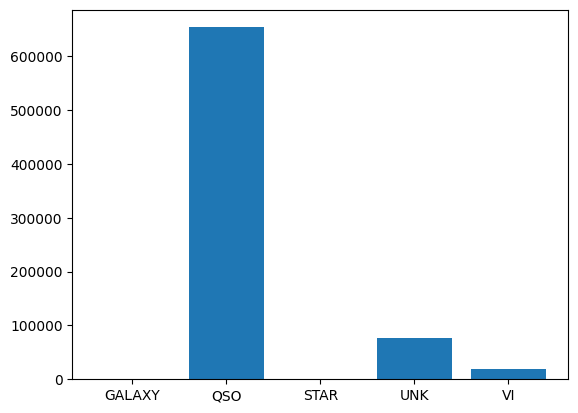

In [15]:
import pandas as pd
 
import matplotlib.pyplot as plt
 
import seaborn as sns

x=Eboss_table['AUTOCLASS_PQN']

keys, counts=np.unique(x, return_counts=True)

plt.bar(keys, counts)
 
   

In [16]:
#recent documentation for converting astropy table to df , as of recently this was an added feature and should
#accurately convert dtypes
#however: Cannot convert a table with multidimensional columns to a pandas DataFrame.



In [17]:
Eboss_ra=Eboss_table['RA']*u.deg #take the ra column from the table, store it in a variable
Eboss_dec=Eboss_table['DEC']*u.deg #take the dec column from the table store it in a variable
Eboss_Coords=SkyCoord(Eboss_ra, Eboss_dec, frame='icrs', unit='deg') #create a coord system with the ra / dec 
Eboss_Coords #output the coords to verify the coords combined, will use this for future matching. 

<SkyCoord (ICRS): (ra, dec) in deg
    [(6.29498925e-04, 35.51784115), (1.41450863e-03, 31.05704784),
     (1.53536894e-03,  7.06412931), ..., (3.59999615e+02,  3.26858617),
     (3.59999759e+02, 20.72107939), (3.59999954e+02, 34.74713329)]>

In [18]:
COMAP_point_one = SkyCoord(ra='01h41m44.4s', dec='00d00m00s')
COMAP_point_two = SkyCoord(ra='11h20m00s', dec='52d30m00s')
COMAP_point_three = SkyCoord(ra='15h04m00s', dec='55d00m00s')


tol=1.5*u.deg

Eboss_sep_point_one=Eboss_Coords.separation(COMAP_point_one)
Eboss_idx_one=np.where(Eboss_sep_point_one < tol)[0]
#field_one_df=Eboss_table.iloc[Eboss_idx_one]  #can't iloc a table w/o indeces 

Eboss_sep_point_two=Eboss_Coords.separation(COMAP_point_two)
Eboss_idx_two=np.where(Eboss_sep_point_two<tol)[0]
#field_two_df=Ebosstable.iloc[Eboss_idx_two]

Eboss_sep_point_three=Eboss_Coords.separation(COMAP_point_three)
Eboss_idx_three=np.where(Eboss_sep_point_three<tol)[0]
#field_three_df=Eboss_table.iloc[Eboss_idx_three]


#pd.concat (df1,df2,df3) combines several dataframes together) 
#combined_df=pd.concat((field_one_df,field_two_df,field_three_df))


#there is no indeces because there is no data near these points 

In [19]:
#Data from region stripe 82 within Ra: 60 to 300 & Dec -1.26 to 1.26 from the Eboss data set 
Eboss_Stripe_table=Eboss_table[(Eboss_table['RA']>60) & (Eboss_table['RA']<300)&(Eboss_table['DEC']>-1.26) & (Eboss_table['DEC']<1.26)  ]

<BarContainer object of 5 artists>

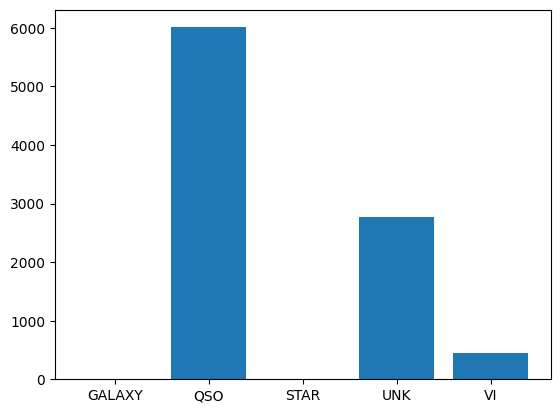

In [20]:
Eboss_Stripe_table
#output the Eboss data in stripe 82 , table length 9249 (usable)


import pandas as pd
 
import matplotlib.pyplot as plt
 
import seaborn as sns

x=Eboss_Stripe_table['AUTOCLASS_PQN']

keys, counts=np.unique(x, return_counts=True)

plt.bar(keys, counts)

Repeat process for prior fits for DesiQ fits.

Now start exploring how to work directly with astropy tables:

https://docs.astropy.org/en/stable/table/

https://docs.astropy.org/en/stable/table/pandas.html

Cannot convert so, will be working with tables over df as there are multi-dimensional columns. 
"Cannot convert a table with multidimensional columns to a pandas DataFrame."



Desi data set explanation: https://data.desi.lbl.gov/doc/releases/edr/vac/balqso/


In [21]:
HudlDesiQ=fits.open("/kaggle/input/desi-early-data-release/QSO_cat_fuji_sv1_dark_bal_mask_v1.0.fits")
DesiQHeader=HudlDesiQ[1].header
DesiQdata=HudlDesiQ[1].data
DesiQCols=HudlDesiQ[1].columns
DesiQ_table = Table(HudlDesiQ[1].data)  



#spectype: Galaxy , Quasar, etc. 

#z - redshift amount

#z-error (error amoutn for z)

Z_RR   Redshift collected from redrock file

Z_QN   Redshift measured by QuasarNET using line with highest confidence'


The redrock and quasarnet are files that are pulled into this dataset 


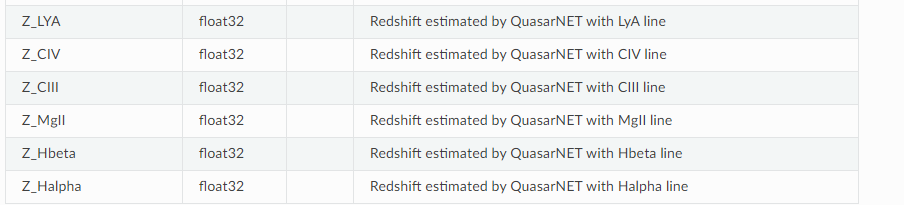

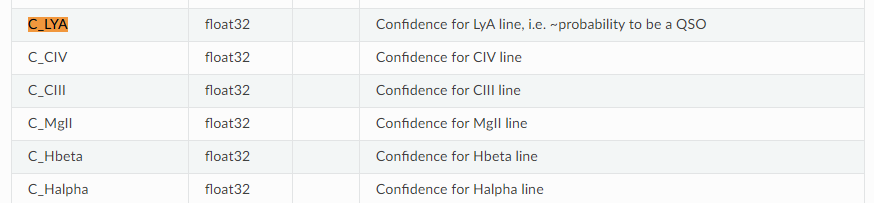


All of the Z above are good. 


https://en.wikipedia.org/wiki/Photometric_system 
Flux from the bands in the article above

Flux_G

Flux_R

Flux_z 


EBV - (magnitutde)  Galactic extinction E(B-V) reddening from SFD98 The extinction due to dust is not equally effective at all wavelengths. The shorter the wavelength, the higher the extinction -- blue light is affected more strongly than red light. Therefore, stars behind a lot of dust look redder than they really are. This is called interstellar reddening.

https://gea.esac.esa.int/archive/documentation//GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html

All Gia is decent to look at

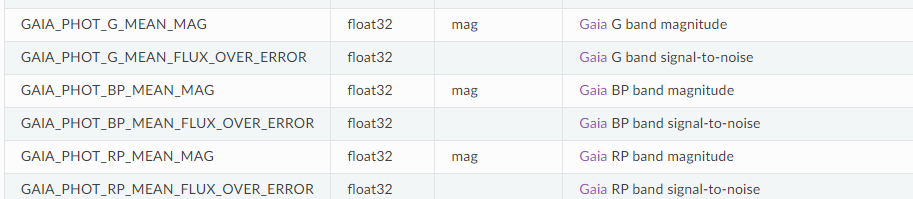

But its not in the data 

In [22]:
DesiQ_table

TARGETID,Z,ZERR,ZWARN,SPECTYPE,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,PROBA_RF,MASKBITS,SV1_DESI_TARGET,SV1_SCND_TARGET,DESI_TARGET,COADD_NUMEXP,COADD_EXPTIME,CMX_TARGET,SV2_DESI_TARGET,SV3_DESI_TARGET,SV2_SCND_TARGET,SV3_SCND_TARGET,SCND_TARGET,TSNR2_LYA,TSNR2_QSO,DELTA_CHI2_MGII,A_MGII,SIGMA_MGII,B_MGII,VAR_A_MGII,VAR_SIGMA_MGII,VAR_B_MGII,Z_RR,Z_QN,C_LYA,C_CIV,C_CIII,C_MgII,C_Hbeta,C_Halpha,Z_LYA,Z_CIV,Z_CIII,Z_MgII,Z_Hbeta,Z_Halpha,QSO_MASKBITS,HPXPIXEL,SURVEY,PROGRAM,PCA_COEFFS,PCA_CHI2,BAL_PROB,BI_CIV,ERR_BI_CIV,NCIV_2000,VMIN_CIV_2000,VMAX_CIV_2000,POSMIN_CIV_2000,FMIN_CIV_2000,AI_CIV,ERR_AI_CIV,NCIV_450,VMIN_CIV_450,VMAX_CIV_450,POSMIN_CIV_450,FMIN_CIV_450,BI_SIIV,ERR_BI_SIIV,NSIIV_2000,VMIN_SIIV_2000,VMAX_SIIV_2000,POSMIN_SIIV_2000,FMIN_SIIV_2000,AI_SIIV,ERR_AI_SIIV,NSIIV_450,VMIN_SIIV_450,VMAX_SIIV_450,POSMIN_SIIV_450,FMIN_SIIV_450,BALMASK,Z_MASK,ZERR_MASK,ZWARN_MASK,CHI2_MASK,DELTACHI2_MASK,SPECTYPE_MASK,SNR_CIV
int64,float64,float64,int64,str6,int32,float64,float64,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,int16,int64,int64,int64,int16,float32,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64,str3,str4,float32[5],float32,float32,float32,float32,int32,float32[5],float32[5],float32[5],float32[5],float32,float32,int32,float32[17],float32[17],float32[17],float32[17],float32,float32,int32,float32[5],float32[5],float32[5],float32[5],float32,float32,int32,float32[17],float32[17],float32[17],float32[17],uint8,float64,float64,int64,float64,float64,str6,float64
39628368194306382,0.8140676837556261,2.4708515411475673e-05,0,GALAXY,0,197.05185565318763,24.72539693824657,PSF,0.018278226,4.212872,5.5204306,7.968778,56.41304,71.5306,641.35986,288.39368,86.60178,2.5183556,0.61669296,0.9406437824442196,0.9406437824442196,0.9406437824442196,0.9406437824442196,0.9406437824442196,0.9962809027433396,768,4620978815911346007,131072,0,5,3735.5789,0,0,0,0,0,0,398.04037,162.13881,798.2196,0.68594104,51.28113,0.97744566,0.0036955306,40.5517,0.004181951,0.81397045,0.81250525,1.5951437e-05,1.4724984e-05,3.2260526e-05,0.9999999,0.99999976,4.8045945e-06,4.355075,4.3772316,0.9477634,0.81250525,0.8135503,-0.25143924,28,10282,sv1,dark,0.0 .. 0.0,0.0,-99.0,0.0,0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,5,-1.0,-1.0,-1,-1.0,-1.0,-1,-1.0
39628368194307737,1.2929035773170077,7.951630821317108e-05,0,QSO,0,197.12264856975852,24.677197913155375,PSF,0.021187862,2.6756825,4.290999,5.50415,9.259546,13.74744,1292.5627,417.89807,72.94945,3.4788496,0.7615722,0.9315257267727525,0.9315257267727525,0.9315257267727525,0.9315257267727525,0.9315257267727525,0.9926938264369964,0,4665729213955883012,34359869440,0,6,4035.6438,0,0,0,0,0,0,386.18692,160.3963,260.10394,0.64678776,41.64146,1.264349,0.00082744984,7.5426626,0.0006395382,1.2929035,1.2939914,0.00015168663,0.00045015922,0.9999906,0.99999905,0.00011424085,9.170406e-05,2.3687553,1.3252736,1.2940029,1.2939914,0.5852461,0.48824963,14,10282,sv1,dark,0.0 .. 0.0,0.0,-99.0,0.0,0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,5,-1.0,-1.0,-1,-1.0,-1.0,-1,-1.0
39628357184262231,0.8135438091215956,1.5672871326882497e-05,0,QSO,0,197.20380147240678,24.35077016605972,PSF,0.017858109,10.67686,12.232638,13.990282,18.791878,25.71

In [23]:
Desi_ra=DesiQ_table['TARGET_RA']*u.deg
Desi_dec=DesiQ_table['TARGET_DEC']*u.deg
Desi_Coords=SkyCoord(Desi_ra, Desi_dec, frame='icrs', unit='deg')
Desi_Coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(197.05185565, 24.72539694), (197.12264857, 24.67719791),
     (197.20380147, 24.35077017), ..., (235.32292921, 33.8193507 ),
     (235.43962021, 33.66658852), (235.63283787, 33.60772268)]>

In [24]:
COMAP_point_one = SkyCoord(ra='01h41m44.4s', dec='00d00m00s')
COMAP_point_two = SkyCoord(ra='11h20m00s', dec='52d30m00s')
COMAP_point_three = SkyCoord(ra='15h04m00s', dec='55d00m00s')


tol=1.5*u.deg

Desi_sep_point_one=Desi_Coords.separation(COMAP_point_one)
Desi_idx_one=np.where(Desi_sep_point_one < tol)[0]
#field_one_df=DesiQ_table.iloc[Desi_idx_one]  #can't iloc a table w/o indeces 

Desi_sep_point_two=Desi_Coords.separation(COMAP_point_two)
Desi_idx_two=np.where(Desi_sep_point_two<tol)[0]
#field_two_df=DesiQ_table.iloc[Desi_idx_two]

Desi_sep_point_three=Desi_Coords.separation(COMAP_point_three)
Desi_idx_three=np.where(Desi_sep_point_three<tol)[0]
#field_three_df=DesiQ_table.iloc[Desi_idx_three]


#pd.concat (df1,df2,df3) combines several dataframes together) 
#combined_df=pd.concat((field_one_df,field_two_df,field_three_df))


#there is no indeces because there is no data near these points 

In [25]:
#Data from region stripe 82 within Ra: 60 to 300 & Dec -1.26 to 1.26 from the desi Q data set 
DesiQ_Stripe_table=DesiQ_table[(DesiQ_table['TARGET_RA']>60) & (DesiQ_table['TARGET_RA']<300)&(DesiQ_table['TARGET_DEC']>-1.26) & (DesiQ_table['TARGET_DEC']<1.26)  ]

<BarContainer object of 2 artists>

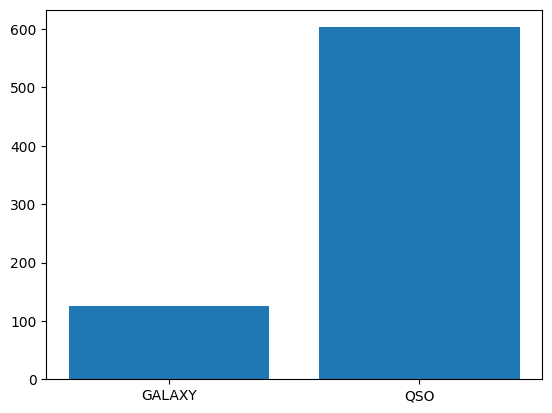

In [26]:
DesiQ_Stripe_table

import pandas as pd
 
import matplotlib.pyplot as plt
 
import seaborn as sns

x=DesiQ_Stripe_table['SPECTYPE']

keys, counts=np.unique(x, return_counts=True)

plt.bar(keys, counts)


***********NOT USABLE IMAGE ONLY HAVE TO CALIBRATE*********************
https://irsa.ipac.caltech.edu/data/COSMOS/images/3D-HST/3dhst_readme_v4.1.pdf
https://irsa.ipac.caltech.edu/data/COSMOS/images/3D-HST/f140w/?C=D;O=A

COSMOS/images/3D-HST/f140w

IR-new2	F140W	Wide Band spanning J-H boundary
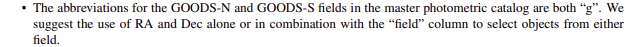

In [27]:
#HudlHF140W=fits.open("/kaggle/input/cosmo-hst-f140w/cosmos_3dhst.v4.0.F140W_conv_sci.fits")
#HF140WHeader=HudlHF140W[0].header
#HF140Wdata=HudlHF140W[0].data


In [28]:
#HF140Wdata
#image only not very usable 


***********NOT USABLE IMAGE ONLY HAVE TO CALIBRATE*********************


https://irsa.ipac.caltech.edu/data/COSMOS/overview.html

To find IR band data worthy of going through.

HST IR 1 - F125W 2 Broad J IR
HST IR 2  -F160W   Broad H and Red Grism Ref *


rms file = rms error= A measure of the difference between locations that are known and locations that have been interpolated or digitized

wht file = weight  a weight-map pixel is an estimate of the precision of the measurement provided by the related science image pixel 


which file to download:
https://www.photographingspace.com/hubble-2-data/

_drz
_sci
The two obvious options are the FITS-Science and FITS-MEF. From the cart, you can tell these two apart because the FITS-Science filename ends in _sci and the FITS-MEF (multi-extension FITS) ends in _drz. Both contain an identical image in the first plane. The FITS-MEF contains two additional image planes, one containing a bunch of cosmic rays and other oddities, the other a weight file. I personally have found no use for either of those, so I always choose the FITS-Science file, which can be found under the thumbnails when browsing results from the Image tab.


In [29]:
#HudlHF125W=fits.open("/kaggle/input/candels-hst-f125w/hlsp_candels_hst_wfc3_cos-tot_f125w_v1.0_drz.fits")
#HF125WHeader=HudlHF125W[0].header
#HF125Wdata=HudlHF125W[0].data


In [30]:
#HF125Wdata
#HF125W_table = Table(HudlHF125W[0].data)  